# Modeling & Forecasting: Algeria Socio-Economic Trends

In this phase, we move from descriptive analysis to predictive modeling and structural inference. We employ a multi-stage approach:

1.  **Baseline Models (Traditional ML):** Establishing a benchmark using Linear, Lasso, and Ridge Regression.
2.  **Econometric Modeling (VAR):** To understand the *interdependencies* and *shocks* between key variables.
3.  **Advanced ML (XGBoost):** To maximize predictive accuracy capturing non-linearities.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Plot Settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 1. Data Loading and Preparation

In [7]:
df = pd.read_csv('../data/processed/algeria_featured.csv')
df['Year'] = pd.to_datetime(df['Year'])
df = df.set_index('Year')

target = 'GDP_Growth'
features = [c for c in df.columns if c != target]

# Train/Test Split (Time-based)
split_date = '2015-01-01'
X = df[features]
y = df[target]

X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

# Scaling for Linear Models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (53, 32), Test shape: (8, 32)


## 2. Baseline Models (Linear, Lasso, Ridge)
We start with interpretable regression models to establish a performance baseline.

Linear Regression RMSE: 15.6408
Lasso (L1) RMSE: 2.3202
Ridge (L2) RMSE: 3.2202


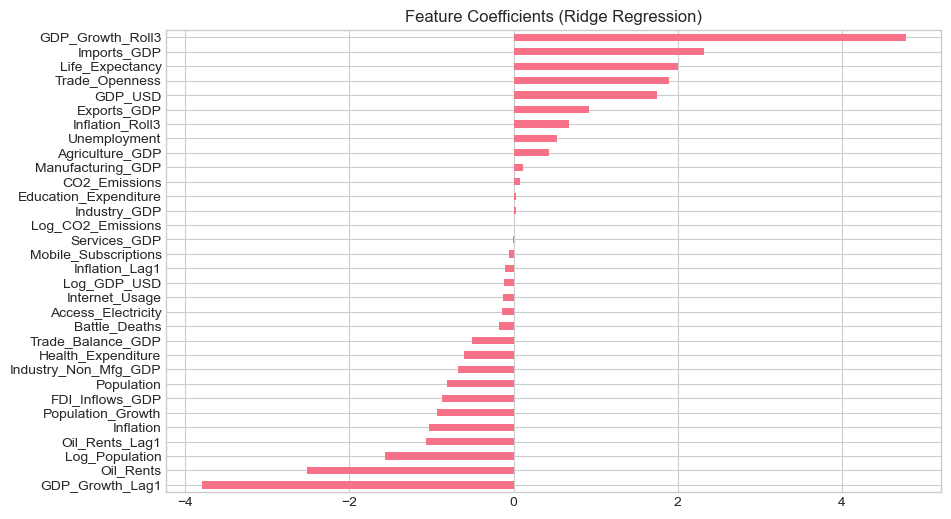

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso (L1)": Lasso(alpha=0.1),
    "Ridge (L2)": Ridge(alpha=1.0)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.4f}")
    
# Visualize Coefficients for Interpretation (Ridge)
ridge = models["Ridge (L2)"]
coefs = pd.Series(ridge.coef_, index=features).sort_values()
plt.figure(figsize=(10, 6))
coefs.plot(kind='barh')
plt.title('Feature Coefficients (Ridge Regression)')
plt.show()

## 3. Stationarity Checks & VAR Model
Analyzing structural relationships and shocks.

c:\Users\badro\anaconda3\envs\intro_to_ai_lab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


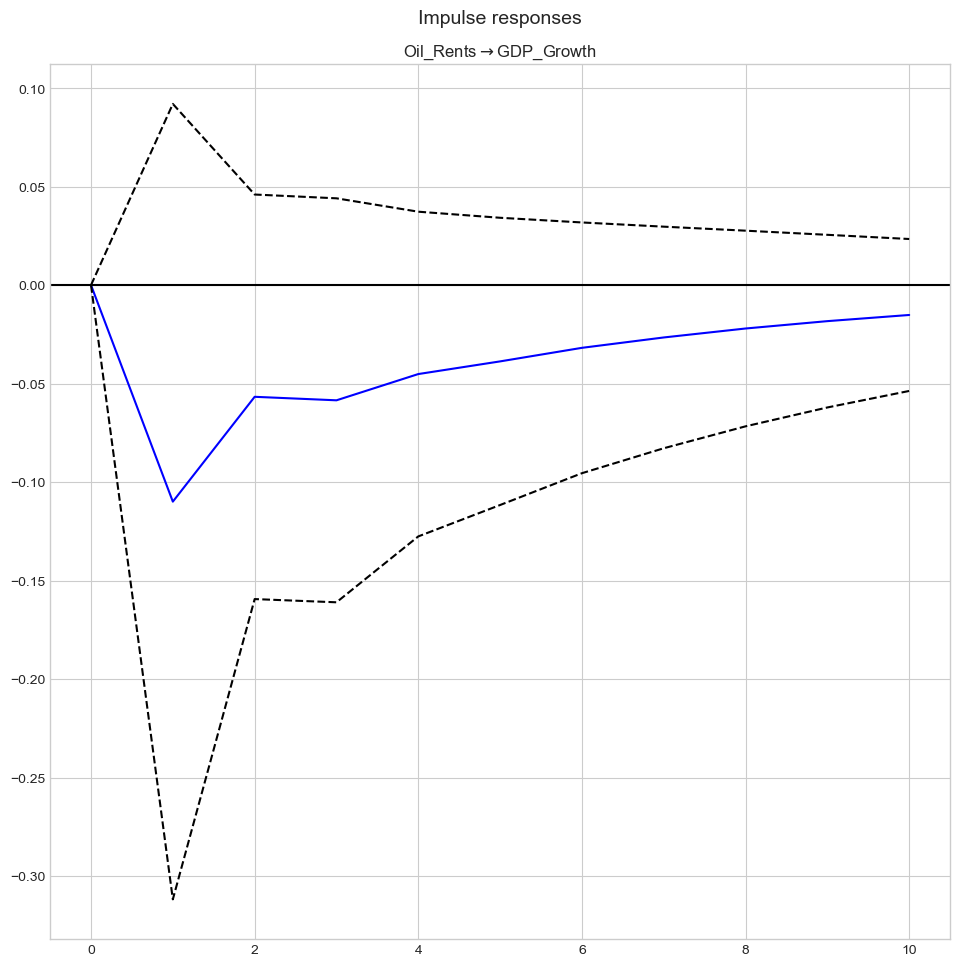

In [9]:
var_cols = ['GDP_Growth', 'Oil_Rents', 'Inflation']
data_var = df[var_cols].dropna()

model = VAR(data_var)
lag_order = model.select_order(maxlags=5)
var_model = model.fit(lag_order.aic)

# Impulse Response
irf = var_model.irf(10)
irf.plot(orth=False, impulse='Oil_Rents', response='GDP_Growth')
plt.show()

## 4. Advanced ML: XGBoost
Attempting to beat the baseline with non-linear tree boosting.

XGBoost RMSE: 6.4287


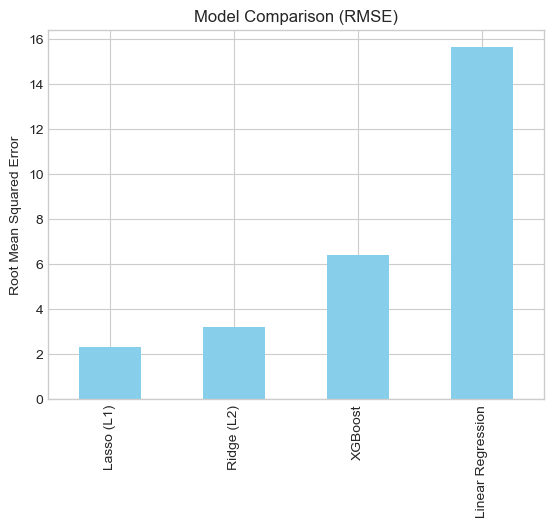

In [10]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

results['XGBoost'] = xgb_rmse
print(f"XGBoost RMSE: {xgb_rmse:.4f}")

# Model Comparison Plot
pd.Series(results).sort_values().plot(kind='bar', color='skyblue')
plt.title('Model Comparison (RMSE)')
plt.ylabel('Root Mean Squared Error')
plt.show()